In [1]:
import rootutils

rootutils.setup_root("./", indicator=".project-root", pythonpath=True)

%load_ext autoreload
%autoreload 2

import hydra
import torch
import torch_geometric
from hydra import compose, initialize
from omegaconf import OmegaConf

from topobenchmarkx.data.preprocessor import PreProcessor
from topobenchmarkx.dataloader.dataloader import TBXDataloader
from topobenchmarkx.data.loaders import GraphLoader

from topobenchmarkx.utils.config_resolvers import (
    get_default_transform,
    get_monitor_metric,
    get_monitor_mode,
    infer_in_channels,
)


initialize(config_path="../configs", job_name="job")

/tmp/ipykernel_45596/2455096930.py:26: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../configs", job_name="job")


hydra.initialize()

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
from matplotlib.patches import Polygon
from itertools import combinations
from typing import Optional, Dict, List

def plot_graph(
    data,
    face_color_map: Optional[Dict[int, str]] = None,
    node_size: int = 500,
    font_size: int = 12,
    seed: int = 5,
    show: bool = True
) -> plt.Figure:
    """
    Visualize a simplicial complex from a PyTorch Geometric Data object.
    
    Args:
        data: torch_geometric.data.Data object containing the simplicial complex
        face_color_map: Dictionary mapping number of tetrahedrons to colors
        node_size: Size of nodes in the visualization
        font_size: Size of font for labels
        seed: Random seed for layout
        show: Whether to display the plot immediately
    
    Returns:
        matplotlib.figure.Figure: The generated figure
    """
    # Default color map if none provided
    if face_color_map is None:
        face_color_map = {
            0: "pink",
            1: "gray",
            2: "blue",
            3: "blue",
            4: "orange",
            5: "purple",
            6: "red",
            7: "brown",
            8: "black",
            9: "gray",
        }
    
    # Extract vertices
    num_vertices = data.num_nodes if hasattr(data, 'num_nodes') else data.x.shape[0]
    vertices = list(range(num_vertices))
    
    # Extract edges from incidence matrix
    edges = []
    for edge in abs(data.incidence_1.to_dense().T):
        edges.append(torch.where(edge == 1)[0].numpy())
    edges = np.array(edges)
    
    # Extract tetrahedrons if available
    tetrahedrons = []
    if hasattr(data, 'tetrahedrons'):
        tetrahedrons = data.tetrahedrons
    elif hasattr(data, 'incidence_2'):
        # Extract tetrahedrons from incidence_2 matrix if available
        for tetra in abs(data.incidence_2.to_dense().T):
            tetrahedrons.append(torch.where(tetra == 1)[0].tolist())
    
    # Create graph
    G = nx.Graph()
    G.add_nodes_from(vertices)
    G.add_edges_from(edges)
    
    # Find triangular cliques
    cliques = list(nx.enumerate_all_cliques(G))
    cliques = [triangle for triangle in cliques if len(triangle) == 3]
    
    # Create layout
    pos = nx.spring_layout(G, seed=seed)
    
    # Create figure
    fig = plt.figure(figsize=(10, 8))
    
    # Draw nodes and labels
    nx.draw(
        G,
        pos,
        labels={i: f"v_{i}" for i in G.nodes()},
        node_size=node_size,
        node_color="skyblue",
        font_size=font_size,
    )
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="g", width=2, alpha=0.5)
    
    # # Add edge labels
    for i, (u, v) in enumerate(edges):
        x = (pos[u][0] + pos[v][0]) / 2
        y = (pos[u][1] + pos[v][1]) / 2
        plt.text(x, y, f"e_{i}", fontsize=font_size - 2, color="r")
    
    # Color the faces (cliques)
    for clique in cliques:
        # Count tetrahedrons containing this clique
        counter = 0
        for tetrahedron in tetrahedrons:
            for comb in combinations(tetrahedron, 3):
                if set(clique) == set(comb):
                    counter += 1
        
        # Create and add polygon
        polygon = [pos[v] for v in clique]
        poly = Polygon(
            polygon,
            closed=True,
            facecolor=face_color_map.get(counter, "gray"),  # Default to gray if counter not in map
            edgecolor="pink",
            alpha=0.3,
        )
        plt.gca().add_patch(poly)
    
    plt.title(f"Graph with cliques colored ({num_vertices} vertices)")
    
    if show:
        plt.show()
    

In [3]:
from torch_geometric.loader import NeighborLoader

# replace adjacency keys with temp
def workaround_data(data):
    """ The function is a workaround to change the data to work with NeighborLoader. 
    
    The function replaces the keys with adjacency in the name with temp. It also removes the shape attribute if present.
    
    Parameters
    ----------
    data: torch_geometric.data.Data
        The input data.
        
    Returns
    -------
    torch_geometric.data.Data
        The output data with the keys replaced and the shape attribute removed.
    """
    n_adjacencies = len([key for key in data.keys() if "adjacency" in key])
    for i in range(n_adjacencies):
        if f"adjacency_{i}" in data.keys():
            data[f"temp_{i}"] = data[f"adjacency_{i}"]
            del data[f"adjacency_{i}"]
    
    # shape is a list, it breaks the NeighborLoader if we keep it
    if hasattr(data, 'shape'):
        del data.shape
    return data

def get_sampled_neighborhood(data, rank=0, is_hypergraph=False):
    ''' This function updates the edge_index attribute of torch_geometric.data.Data. 
    
    The function finds cells, of the specified rank, that are either upper or lower neighbors.
    
    Parameters
    ----------
    data: torch_geometric.data.Data
        The input data.
    rank: int
        The rank of the cells that you want to batch over.
    is_hypergraph: bool
        Whether the data represents an hypergraph.
        
    Returns
    -------
    torch_geometric.data.Data
        The output data with updated edge_index.
        edge_index contains indices of connected cells of the specified rank K.  
        Two cells of rank K are connected if they are either lower or upper neighbors. 
    '''
    if rank == 0:
        return data
    if is_hypergraph: 
        if rank > 1:
            raise ValueError("Hypergraphs are not supported for ranks greater than 1.")
        if rank == 1:
            I = data.incidence_hyperedges
            A = torch.sparse.mm(I,I.T) # lower adj matrix
            edges = A.indices()
        else:
            I = data.incidence_hyperedges
            A = torch.sparse.mm(I.T,I)
            edges = A.indices() 
    else:
        # get number of incidences
        max_rank = len([key for key in data.keys() if "incidence" in key])-1
        if rank > max_rank:
            raise ValueError(f"Rank {rank} is greater than the maximum rank {max_rank} in the data.")
        
        # This considers the upper adjacencies
        if rank == max_rank:
            edges = torch.empty((2, 0), dtype=torch.long)
        else:
            I = data[f"incidence_{rank+1}"]
            A = torch.sparse.mm(I,I.T)
            edges = A.indices()
            
        # This is for selecting the whole upper cells
        # for i in range(rank+1, max_rank):
        #     P = torch.sparse.mm(P, data[f"incidence_{i+1}"])
        #     Q = torch.sparse.mm(P,P.T)
        #     edges = torch.cat((edges, Q.indices()), dim=1)
        
        # This considers the lower adjacencies
        if rank != 0:    
            I = data[f"incidence_{rank}"]
            A = torch.sparse.mm(I.T,I)
            edges = torch.cat((edges, A.indices()), dim=1)
        
        # This is for selecting cells if they share any node
        # for i in range(rank-1, 0, -1):
        #     P = torch.sparse.mm(data[f"incidence_{i}"], P)
        #     Q = torch.sparse.mm(P.T,P)
        #     edges = torch.cat((edges, Q.indices()), dim=1)
            
    edges = torch.unique(edges, dim=1)
    # Remove self edges
    mask = edges[0, :] != edges[1, :]
    edges = edges[:, mask]
    
    data.edge_index = edges
    
    # We need to set x to x_{rank} since NeighborLoader will take the number of nodes from the x attribute
    # The correct x is given after the reduce_neighborhoods function
    if is_hypergraph and rank == 1:
        data.x = data.x_hyperedges
    else:
        data.x = data[f'x_{rank}']
    
    if hasattr(data, 'num_nodes'):
        data.num_nodes = data.x.shape[0]
    return data

def reduce_higher_ranks_incidences(batch, cells_ids, rank, max_rank, is_hypergraph=False):
    """ Reduce the incidences with higher rank than the specified one.
    
    Parameters
    ----------
    batch: torch_geometric.data.Data
        The input data.
    cells_ids: list[torch.Tensor]
        List of tensors containing the ids of the cells. The length of the list should be equal to the maximum rank.
    rank: int
        The rank to select the higher order incidences.
    max_rank: int
        The maximum rank of the incidences.
    is_hypergraph: bool
        Whether the data represents an hypergraph.
        
    Returns
    -------
    torch_geometric.data.Data
        The output data with the reduced incidences.
    list[torch.Tensor]
        The updated indices of the cells. Each element of the list is a tensor containing the ids of the cells of the corresponding rank.
    """
    for i in range(rank+1, max_rank+1):
        if is_hypergraph:
            incidence = batch.incidence_hyperedges
        else:
            incidence = batch[f"incidence_{i}"]
            
        if i != rank+1:
            incidence = torch.index_select(incidence, 0, cells_ids[i-1])
        cells_ids[i] = torch.where(torch.sum(incidence, dim=0).to_dense() > 1)[0]
        incidence = torch.index_select(incidence, 1, cells_ids[i])
        batch[f"incidence_{i}"] = incidence
    
    return batch, cells_ids

def reduce_lower_ranks_incidences(batch, cells_ids, rank, is_hypergraph=False):
    """ Reduce the incidences with lower rank than the specified one.
    
    Parameters
    ----------
    batch: torch_geometric.data.Data
        The input data.
    cells_ids: list[torch.Tensor]
        List of tensors containing the ids of the cells. The length of the list should be equal to the maximum rank.
    rank: int
        The rank of the cells to consider.
    is_hypergraph: bool
        Whether the data represents an hypergraph.
    
    Returns
    -------
    torch.Tensor
        The indices of the nodes contained by the cells.
    list[torch.Tensor]
        The updated indices of the cells. Each element of the list is a tensor containing the ids of the cells of the corresponding rank.
    """
    for i in range(rank, 0, -1):
        if is_hypergraph:
            incidence = batch.incidence_hyperedges
        else:
            incidence = batch[f"incidence_{i}"]
        incidence = torch.index_select(incidence, 1, cells_ids[i])
        cells_ids[i-1] = torch.where(torch.sum(incidence, dim=1).to_dense() > 0)[0]
        incidence = torch.index_select(incidence, 0, cells_ids[i-1])
        batch[f"incidence_{i}"] = incidence
        
    if not is_hypergraph:
        incidence = batch[f"incidence_0"]
        incidence = torch.index_select(incidence, 1, cells_ids[0])
        batch[f"incidence_0"] = incidence
    return batch, cells_ids

def reduce_matrices(batch, cells_ids, names, rank, max_rank):
    """ Reduce the matrices using the indices in cells_ids. 
    
    The matrices are assumed to be in the batch with the names specified in the list names.
    
    Parameters
    ----------
    batch: torch_geometric.data.Data
        The input data.
    cells_ids: list[torch.Tensor]
        List of tensors containing the ids of the cells. The length of the list should be equal to the maximum rank.
    names: list[str]
        List of names of the matrices in the batch. They should appear in the format f"{name}{i}" where i is the rank of the matrix.
    rank: int
        The rank over which you are batching.
    max_rank: int
        The maximum rank of the matrices.
    
    Returns
    -------
    torch_geometric.data.Data
        The output data with the reduced matrices.
    """
    for i in range(max_rank+1):
        for name in names:
            if f"{name}{i}" in batch.keys():
                matrix = batch[f"{name}{i}"]
                if i==rank:
                    matrix = torch.index_select(matrix, 1, cells_ids[i])
                else:
                    matrix = torch.index_select(matrix, 0, cells_ids[i])
                    matrix = torch.index_select(matrix, 1, cells_ids[i])
                batch[f"{name}{i}"] = matrix
    return batch

def reduce_neighborhoods(batch, rank=0, remove_self_loops=True):
    """ Reduce the neighborhoods of the cells in the batch.
    
    Parameters
    ----------
    batch: torch_geometric.data.Data
        The input data.
    rank: int
        The rank of the cells to batch over.
    remove_self_loops: bool
        Whether to remove self loops from the edge_index.
    
    Returns
    -------
    torch_geometric.data.Data
        The output data with the reduced neighborhoods.
    """
    is_hypergraph = False
    if hasattr(batch, 'incidence_hyperedges'):
        is_hypergraph = True
        max_rank = 1
    else:
        max_rank = len([key for key in batch.keys() if "incidence" in key])-1
    
    if rank > max_rank:
        raise ValueError(f"Rank {rank} is greater than the maximum rank {max_rank} in the dataset.")
    
    cells_ids = [None for _ in range(max_rank+1)]
    
    # the indices of the cells selected by the NeighborhoodLoader are saved in the batch in the attribute n_id
    cells_ids[rank] = batch.n_id
        
    batch, cells_ids = reduce_higher_ranks_incidences(batch, cells_ids, rank, max_rank, is_hypergraph)
    batch, cells_ids = reduce_lower_ranks_incidences(batch, cells_ids, rank, is_hypergraph)
    
    batch = reduce_matrices(batch, 
                            cells_ids, 
                            names=['down_laplacian_', 'up_laplacian_', 'hodge_laplacian_', 'temp_'],
                            rank=rank,
                            max_rank=max_rank)
                
    # reduce the feature matrices
    for i in range(max_rank+1):
        if i != rank:
            if f"x_{i}" in batch.keys():
                batch[f"x_{i}"] = batch[f"x_{i}"][cells_ids[i]]
            
    # change the temp matrices back to adjacency
    for i in range(max_rank+1):
        if f"temp_{i}" in batch.keys():
            batch[f"adjacency_{i}"] = batch[f"temp_{i}"]
            del batch[f"temp_{i}"]
            
    # fix edge_index
    if not is_hypergraph:
        adjacency_0 = batch.adjacency_0.coalesce()
        edge_index = adjacency_0.indices()
        if remove_self_loops:
            edge_index = torch_geometric.utils.remove_self_loops(edge_index)[0]
        batch.edge_index = edge_index
    
    # fix x
    batch.x = batch[f"x_0"]
    if hasattr(batch, 'num_nodes'):
        batch.num_nodes = batch.x.shape[0]
    
    return batch

class ReduceNeighborhoods():
    """ Reduce the neighborhoods of the cells in the batch.
    
    Parameters
    ----------
    rank: int
        The rank of the cells to batch over.
    remove_self_loops: bool
        Whether to remove self loops from the edge_index.
    """
    
    def __init__(self, rank=0, remove_self_loops=True):
        self.rank = rank
        self.remove_self_loops = remove_self_loops
        
    def __call__(self, batch):
        """ Call reduce_neighborhoods.
        
        Parameters
        ----------
        batch: torch_geometric.data.Data
            The input data.
        
        Returns
        -------
        torch_geometric.data.Data
            The output data with the reduced neighborhoods.
        """
        return reduce_neighborhoods(batch, self.rank, self.remove_self_loops)

class NeighborLoaderWrapper(NeighborLoader):
    """ Wrapper that applies the needed transformations to the data before passing it to NeighborLoader.
    
    Parameters
    ----------
    dataset: torch_geometric.data.Dataset
        The input dataset.
    rank: int
        The rank of the cells to batch over.
    **kwargs: dict
        Additional arguments for the NeighborLoader.
    """
    def __init__(self, data, rank=0, **kwargs):
        is_hypergraph = hasattr(data, 'incidence_hyperedges')
        data = get_sampled_neighborhood(data, rank, is_hypergraph)
        # This workaround is needed because torch_geometric treats any attribute of data with adj in the name differently and it raises errors.
        data = workaround_data(data)
        if 'num_neighbors' in kwargs.keys():
            if len(kwargs['num_neighbors']) > 1:
                raise NotImplementedError("NeighborLoaderWrapper only supports one-hop neighborhood selection.")
        super(NeighborLoaderWrapper, self).__init__(data, **kwargs)
        

### Manual Graph

Transform parameters are the same, using existing data_dir: ./graph2simplicial_lifting/131528455
Data(x=[8, 1], edge_index=[2, 13], y=[8], num_nodes=8, incidence_0=[1, 8], down_laplacian_0=[8, 8], up_laplacian_0=[8, 8], adjacency_0=[8, 8], hodge_laplacian_0=[8, 8], incidence_1=[8, 13], down_laplacian_1=[13, 13], up_laplacian_1=[13, 13], adjacency_1=[13, 13], hodge_laplacian_1=[13, 13], incidence_2=[13, 6], down_laplacian_2=[6, 6], up_laplacian_2=[6, 6], adjacency_2=[6, 6], hodge_laplacian_2=[6, 6], incidence_3=[6, 1], down_laplacian_3=[1, 1], up_laplacian_3=[1, 1], adjacency_3=[1, 1], hodge_laplacian_3=[1, 1], shape=[4], x_0=[8, 1], x_1=[13, 1], x_2=[6, 1], x_3=[1, 1])


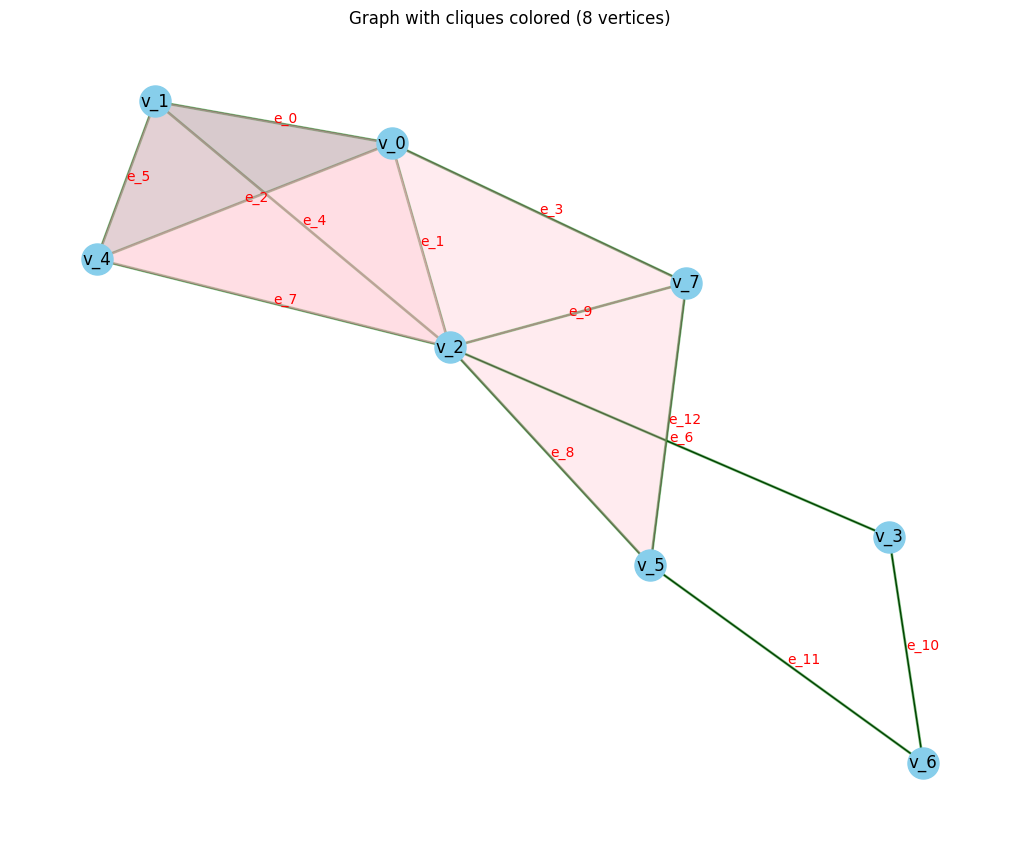

In [4]:
from topobenchmarkx.data.utils.utils import load_manual_graph

cfg = compose(config_name="run.yaml", 
              overrides=["dataset=graph/manual_dataset", "model=simplicial/san"], 
              return_hydra_config=True)
data = load_manual_graph()
preprocessed_dataset = PreProcessor(data, './', cfg['transforms'])
data = preprocessed_dataset[0]
print(data)
plot_graph(data)

In [5]:
# Training, validation and split idxs should be defined somewhere, here we use a toy example
rank = 1
if hasattr(data, "x_hyperedges") and rank==1:
    n_cells = data.x_hyperedges.shape[0]
else:
    n_cells = data[f'x_{rank}'].shape[0]

train_prop = 0.5
n_train = int(train_prop * n_cells)
train_mask = torch.zeros(n_cells, dtype=torch.bool)
train_mask[:n_train] = 1

if rank != 0:
    y = torch.zeros(n_cells, dtype=torch.long)
    data.y = y

data

Data(x=[8, 1], edge_index=[2, 13], y=[13], num_nodes=8, incidence_0=[1, 8], down_laplacian_0=[8, 8], up_laplacian_0=[8, 8], adjacency_0=[8, 8], hodge_laplacian_0=[8, 8], incidence_1=[8, 13], down_laplacian_1=[13, 13], up_laplacian_1=[13, 13], adjacency_1=[13, 13], hodge_laplacian_1=[13, 13], incidence_2=[13, 6], down_laplacian_2=[6, 6], up_laplacian_2=[6, 6], adjacency_2=[6, 6], hodge_laplacian_2=[6, 6], incidence_3=[6, 1], down_laplacian_3=[1, 1], up_laplacian_3=[1, 1], adjacency_3=[1, 1], hodge_laplacian_3=[1, 1], x_0=[8, 1], x_1=[13, 1], x_2=[6, 1], x_3=[1, 1])

In [10]:
batch_size = 2

reduce = ReduceNeighborhoods(rank=rank, remove_self_loops=True)

loader = NeighborLoaderWrapper(data,
                               rank=rank,
                               num_neighbors=[-1],
                               input_nodes=train_mask,
                               batch_size=batch_size,
                               shuffle=False,
                               transform=reduce)

Data(x=[7, 1], edge_index=[2, 22], y=[10], num_nodes=7, incidence_0=[1, 7], down_laplacian_0=[7, 7], up_laplacian_0=[7, 7], hodge_laplacian_0=[7, 7], incidence_1=[7, 10], down_laplacian_1=[10, 10], up_laplacian_1=[10, 10], hodge_laplacian_1=[10, 10], incidence_2=[10, 6], down_laplacian_2=[6, 6], up_laplacian_2=[6, 6], hodge_laplacian_2=[6, 6], incidence_3=[6, 1], down_laplacian_3=[1, 1], up_laplacian_3=[1, 1], hodge_laplacian_3=[1, 1], x_0=[7, 1], x_1=[10, 1], x_2=[6, 1], x_3=[1, 1], n_id=[10], e_id=[13], input_id=[2], batch_size=2, adjacency_0=[7, 7], adjacency_1=[10, 10], adjacency_2=[6, 6], adjacency_3=[1, 1])
The cells of rank 1 that were originally selected are tensor([0, 1])


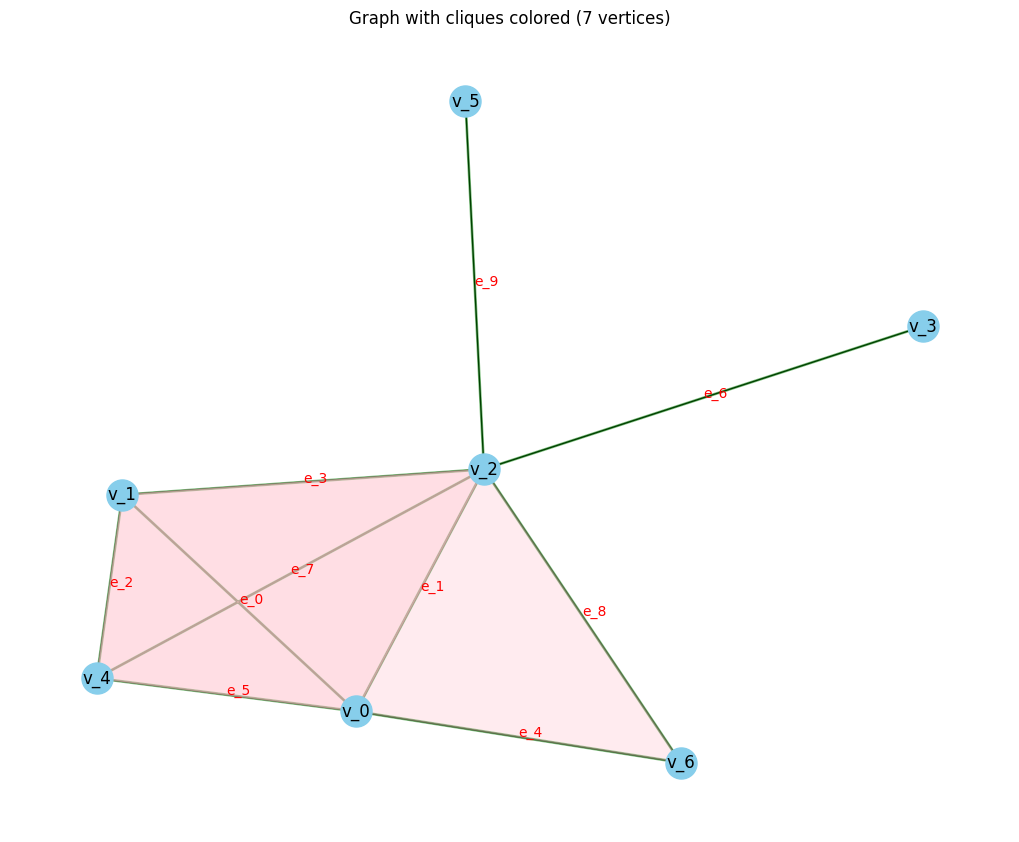

In [13]:
for batch in loader:
    print(batch)
    print(f"The cells of rank {rank} that were originally selected are {batch.n_id[:batch_size]}")
    print(batch.n_id)
    print(batch.edge_index)
    if hasattr(batch, 'incidence_hyperedges'):
        print(batch.incidence_hyperedges.to_dense())
    else:
        print(batch.incidence_3.to_dense())
        print(batch.incidence_2.to_dense())
        print(batch.incidence_1.to_dense())
    plot_graph(batch)
    break

In [ ]:
batch_size = 1

# num_neighbors controls also the number of hops (for 2 hops do num_neighbors=[-1, -1])
reduce = ReduceNeighborhoods(rank=rank, remove_self_loops=True)

loader = NeighborLoaderWrapper(data,
                               rank=rank,
                               num_neighbors=[-1],
                               input_nodes=train_mask,
                               batch_size=batch_size,
                               shuffle=False,
                               transform=reduce)
for batch in loader:
    print(batch)
    print(batch.n_id)
    print(batch.edge_index)
    if hasattr(batch, 'incidence_hyperedges'):
        print(batch.incidence_hyperedges.to_dense())
    else:
        print(batch.incidence_3.to_dense())
        print(batch.incidence_2.to_dense())
        print(batch.incidence_1.to_dense())
    break

plot_graph(batch)

In [ ]:
visualize_simplicial_complex(batch)

In [7]:
cfg = compose(config_name="run.yaml", 
              overrides=["dataset=graph/cocitation_cora", "model=hypergraph/allsettransformer"], 
              return_hydra_config=True)
graph_loader = GraphLoader(cfg.dataset.loader.parameters)
dataset, dataset_dir = graph_loader.load()
preprocessed_dataset = PreProcessor(dataset, './', cfg['transforms'])
data = preprocessed_dataset[0]

# Training, validation and split idxs should be defined somewhere, here we use a toy example
rank = 0
if hasattr(data, "x_hyperedges") and rank==1:
    n_cells = data.x_hyperedges.shape[0]
else:
    n_cells = data[f'x_{rank}'].shape[0]

train_prop = 0.5
n_train = int(train_prop * n_cells)
train_mask = torch.zeros(n_cells, dtype=torch.bool)
train_mask[:n_train] = 1

if rank != 0:
    y = torch.zeros(n_cells, dtype=torch.long)
    data.y = y
batch_size = 1

# num_neighbors controls also the number of hops (for 2 hops do num_neighbors=[-1, -1])
reduce = ReduceNeighborhoods(rank=rank, remove_self_loops=True)

loader = NeighborLoaderWrapper(data,
                               rank=rank,
                               num_neighbors=[-1],
                               input_nodes=train_mask,
                               batch_size=batch_size,
                               shuffle=False,
                               transform=reduce)

Transform parameters are the same, using existing data_dir: ./graph2hypergraph_lifting/1273654097


/usr/local/lib/python3.11/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [8]:
for batch in loader:
    print(batch)
    print(batch.n_id)
    print(batch.edge_index)
    if hasattr(batch, 'incidence_hyperedges'):
        print(batch.incidence_hyperedges.to_dense())
    else:
        print(batch.incidence_3.to_dense())
        print(batch.incidence_2.to_dense())
        print(batch.incidence_1.to_dense())
        
    break

Data(x=[4, 1433], edge_index=[2, 3], y=[4], train_mask=[4], val_mask=[4], test_mask=[4], incidence_hyperedges=[4, 2708], num_hyperedges=2708, x_0=[4, 1433], x_hyperedges=[4, 1433], n_id=[4], e_id=[3], input_id=[1], batch_size=1, incidence_1=[4, 5], num_nodes=4)
tensor([   0, 1862,  633, 2582])
tensor([[1, 2, 3],
        [0, 0, 0]])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
batch

In [ ]:
# for batch in loader:
#     plot_graph(batch)
#     break

In [4]:
if hasattr(data, 'incidence_3'):
    del data['incidence_3']
if hasattr(data, 'x_3'):
    del data['x_3']
for key in list(data.keys()):
    if 'laplacian' in key or 'temp' in key or 'mask' in key or 'hyperedges' in key:
        del data[key]

incidence_3 = torch.tensor([[],[]]).to_sparse()
incidence_2 = torch.tensor([[1,0],[1,0],[1,0],[0,0],[0,1],[0,1],[0,1]]).float().to_sparse()
incidence_1 = torch.tensor([[1,0,1,0,0,0,0],[1,1,0,0,0,0,0],[0,1,1,1,0,0,0],[0,0,0,1,1,0,1],[0,0,0,0,1,1,0],[0,0,0,0,0,1,1]]).float().to_sparse()
incidence_0 = torch.tensor([[1,1,1,1,1,1]]).float().to_sparse()
data  

NameError: name 'data' is not defined

In [ ]:
rank = 0

data['incidence_3'] = incidence_3
data['incidence_2'] = incidence_2
data['incidence_1'] = incidence_1
data['incidence_0'] = incidence_0

data['x_3'] = torch.tensor([]).float()
data['x_2'] = torch.tensor([[1,0],[0,1]]).float()
data['x_1'] = torch.tensor([[1,0,0],[0,1,0],[0,0,1],[1,0,0],[0,1,0],[0,0,1],[1,0,0]]).float()
data['x_0'] = torch.tensor([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]]).float()
data['x'] = data[f'x_{rank}']
data['y'] = torch.zeros(data[f'x_{rank}'].shape[0], dtype=torch.long)

data['edge_index'] = torch.tensor([[0,0,1,1,2,2,2,3,3,3,4,4,5,5],[1,2,0,2,0,1,3,2,4,5,3,5,3,4]])
data['temp_0'] = torch.sparse_coo_tensor(data['edge_index'], torch.ones(data['edge_index'].shape[1]), data['x_0'].shape)
print(data)
plot_graph(data)

In [ ]:
# num_neighbors controls also the number of hops (for 2 hops do num_neighbors=[-1, -1])
reduce = ReduceNeighborhoods(rank=rank, remove_self_loops=True)
batch_size = 1
loader = NeighborLoaderWrapper(data,
                               rank=rank,
                               num_neighbors=[-1],
                               input_nodes=train_mask,
                               batch_size=batch_size,
                               shuffle=False,
                               transform=reduce)

In [ ]:
for i, batch in enumerate(loader):
    if i==2:
        print(batch.adjacency_0.to_dense())
        plot_graph(batch)
        print(batch)
        print(batch.n_id)
        break


In [ ]:
incidence_3 = torch.tensor([[1],[1],[1],[1]]).float().to_sparse()
incidence_2 = torch.tensor([[1,0,1,0],[1,1,0,0],[0,1,1,0],[0,0,1,1],[1,0,0,1],[0,1,0,1]]).float().to_sparse()
incidence_1 = torch.tensor([[1,1,1,0,0,0],[1,0,0,1,1,0],[0,1,0,0,1,1],[0,0,1,1,0,1]]).float().to_sparse()
incidence_0 = torch.tensor([[1,1,1,1]]).float().to_sparse()

x_3 = torch.tensor([[1,0]]).float()
x_2 = torch.tensor([[1,0],[0,1],[1,1],[0,0]]).float()
x_1 = torch.tensor([[1,0,0],[0,1,0],[0,0,1],[1,0,0],[0,1,0],[0,0,1]]).float()
x_0 = torch.tensor([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]).float()

rank = 2

data['incidence_3'] = incidence_3
data['incidence_2'] = incidence_2
data['incidence_1'] = incidence_1
data['incidence_0'] = incidence_0

data['x_3'] = x_3
data['x_2'] = x_2
data['x_1'] = x_1
data['x_0'] = x_0
data['x'] = data[f'x_{rank}']
data['y'] = torch.zeros(data[f'x_{rank}'].shape[0], dtype=torch.long)

data['edge_index'] = torch.tensor([[0,0,0,1,1,1,2,2,2,3,3,3],[1,2,3,0,2,3,0,1,3,0,1,2]])
data['temp_0'] = torch.sparse_coo_tensor(data['edge_index'], torch.ones(data['edge_index'].shape[1]), data['x_0'].shape)
print(data)
plot_graph(data)

In [ ]:
# num_neighbors controls also the number of hops (for 2 hops do num_neighbors=[-1, -1])
reduce = ReduceNeighborhoods(rank=rank, remove_self_loops=True)
batch_size = 1
loader = NeighborLoaderWrapper(data,
                               rank=rank,
                               num_neighbors=[-1],
                               input_nodes=train_mask,
                               batch_size=batch_size,
                               shuffle=False,
                               transform=reduce)

for i, batch in enumerate(loader):
    if i==0:
        plot_graph(batch)
        print(batch)
        print(batch.n_id)
        break